In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import pandas as pd
import numpy as np
from numpy import *
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

import pickle
from keras import backend as K

from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

In [2]:
max_text_len=512
max_summary_len=85

In [3]:
post_pre = pd.read_csv ('../Dataset/Indonesian News Dataset Preprocessed.csv', sep=';')

In [4]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

post_pre['text'] = post_pre['text'].astype(str)
post_pre['summary'] = post_pre['summary'].astype(str)

In [5]:
post_pre.head()

,text,summary
0,jakarta anggota komisi vii dpr ri rofik hanan...,sostok _START_ anggota komisi vii dpr ri rofik...
1,jakarta presiden joko widodo atau jokowi meme...,sostok _START_ presiden joko widodo telah meme...
2,wakil ketua mpr ri dr hidayat nur wahid ma at...,sostok _START_ wakil ketua mpr ri dr hidayat n...
3,jakarta tim kedokteran dan kesehatan dokkes p...,sostok _START_ tim kedokteran dan kesehatan do...
4,ketua mpr ri sekaligus ketua umum ikatan moto...,sostok _START_ ketua mpr ri bambang soesatyo t...


In [6]:
from sklearn.model_selection import train_test_split

# Split data into temporary train set and test/validation set (80%:20%)
x_tr, x_test, y_tr, y_test = train_test_split(
    np.array(post_pre['text']),
    np.array(post_pre['summary']),
    test_size=0.4,
    random_state=0,
    shuffle=True
)

# Split test/validation set into validation set and final test set (50%:50%)
x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=0.5,
    random_state=0,
    shuffle=True
)

In [7]:
print ("Size of Train : ", x_tr.shape)
print ("Size of Test  : ", x_test.shape)
print ("Size of Val   : ", x_val.shape)

Size of Train :  (16804,)
Size of Test  :  (5602,)
Size of Val   :  (5601,)


In [8]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [9]:
#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq  =   x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test = pad_sequences(x_test_seq, maxlen=max_text_len, padding="post")

#size of vocabulary ( +1 for padding token)
x_voc = len(x_tokenizer.word_index) + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 81429


In [10]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [11]:
#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 
y_test_seq  =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = len(y_tokenizer.word_index) + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 35297


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [12]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [13]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [14]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 81429
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 200)             1628580   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 512, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]      

In [15]:
# compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [16]:
# define callbacks|
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [17]:
# Training with a progress bar
hist = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
132/132 [==============================] - 820s 6s/step - loss: 6.5926 - accuracy: 0.2680 - val_loss: 5.8012 - val_accuracy: 0.2840
Epoch 2/50
132/132 [==============================] - 815s 6s/step - loss: 5.7181 - accuracy: 0.2924 - val_loss: 5.5369 - val_accuracy: 0.3056
Epoch 3/50
132/132 [==============================] - 815s 6s/step - loss: 5.6071 - accuracy: 0.3085 - val_loss: 5.4889 - val_accuracy: 0.3176
Epoch 4/50
132/132 [==============================] - 814s 6s/step - loss: 5.5788 - accuracy: 0.3108 - val_loss: 5.4778 - val_accuracy: 0.3177
Epoch 5/50
132/132 [==============================] - 814s 6s/step - loss: 5.5675 - accuracy: 0.3109 - val_loss: 5.4680 - val_accuracy: 0.3163
Epoch 6/50
132/132 [==============================] - 814s 6s/step - loss: 5.5516 - accuracy: 0.3112 - val_loss: 5.4473 - val_accuracy: 0.3171
Epoch 7/50
132/132 [==============================] - 814s 6s/step - loss: 5.5265 - accuracy: 0.3118 - val_loss: 5.4195 - val_accuracy: 0.3183

In [18]:
# Save model, kalau mau load pake cell bawah
model.save('../Model/final_trained_model4.h5')

In [19]:
# save:
f = open('../Model/seq2seq_trained_model_history4.pckl', 'wb')
pickle.dump(hist.history, f)
f.close()

In [20]:
# retrieve:    
f = open('../Model/seq2seq_trained_model_history4.pckl', 'rb')
history = pickle.load(f)
f.close()

In [21]:
# Load saved model

checkpoint_path = "../Model/final_trained_model4.h5"

loaded_model = load_model(checkpoint_path)

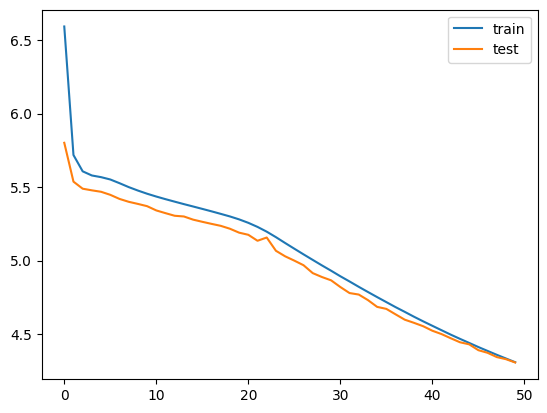

In [22]:
# Plot history
pyplot.plot(history['loss'], label='train')
pyplot.plot(history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [23]:
# set tokenizerz for predictions
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [24]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [25]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [26]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [27]:
for i in range(50,55):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: moms sudah pernah dengan istilah dalam bagi anda yang sedang mungkin perlu mengetahui seputar kondisi medis yang satu ini pada 2019 lalu pesinetron irish bella mengalami pada kehamilan pertamanya yang kala itu hamil anak kembar merupakan kondisi kehamilan saat janin memiliki kelebihan cairan yang tidak normal di sisi lain sang ibu akan mengalami kombinasi preeklamsia dan hidrops komplikasi kehamilan ini termasuk langka lho moms preeklamsia adalah salah satu bentuk tekanan darah tinggi atau hipertensi yang dialami ibu hamil sedangkan hidrops adalah edema atau akumulasi cairan abnormal pada dua atau lebih rongga tubuh seperti di jantung paru paru atau kulit dilansir firstcry parenting kadang kadang terjadi kondisi penumpukan cairan di dalam rongga dan di bawah kulit ibu maupun janin bersama dengan plasentanya bila ada retensi cairan di rongga dan bawah kulit begitu juga plasentanya maka itu bisa disebut juga triple edema yang dapat mengancam nyawa ibu janin maupun keduanya karena

In [28]:
for i in range(0,10):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("\n")

Review: semarang kapolri jenderal listyo sigit prabowo membuka rapat kerja teknis rakernis korps brigade mobile korbrimob polri di gedung akpol semarang jawa tengah jateng hari ini dilaksanakan kegiatan rakernis brimob dipilih tempatnya di akpol tentunya untuk semakin menambah motivasi dan semangat dari seluruh anggota karena akpol ini adalah tempat lahirnya para pemimpin muda dan juga senior senior yang banyak memberikan dedikasi dan dharma bakti untuk brimob dan institusi kepolisian republik indonesia kata sigit senin 13 3 2023 sigit mengungkapkan rakernis brimob ini juga sekaligus menindaklanjuti instruksi dari presiden indonesia joko widodo jokowi ketika memberikan pengarahan di rapat pimpinan rapim tni polri kaitan dengan rakernis tentunya ada perintah dan kebijakan dari bapak presiden saat rapim tni polri yang tentunya harus kita ujar sigit dalam rakernis tersebut dikatakan sigit jajaran brimob polri diantaranya akan membahas kesiapan dalam menghadapi agenda nasional maupun inter

In [29]:
# import csv

# # Open a CSV file in write mode
# with open('results.csv', mode='w', newline='', encoding='utf-8') as file:
#     writer = csv.writer(file)
#     # Write the headers
#     writer.writerow(['Review', 'Original Summary', 'Predicted Summary'])
    
#     # Iterate through the data
#     for i in range(200):
#         review = seq2text(x_test[i])
#         original_summary = seq2summary(y_test[i])
#         predicted_summary = decode_sequence(x_test[i].reshape(1, max_text_len))
        
#         # Write the data to the CSV file
#         writer.writerow([review, original_summary, predicted_summary])

In [30]:
seq2text(x_test[1])

'pt angkasa pura atau bicara mengenai kemungkinan penerbangan timnas ke bali jelang keikutsertaan israel di ajang tersebut memang menjadi sorotan publik gubernur wayan koster bahkan mengirim surat ke menteri pemuda dan olahraga yang saat itu masih dijabat zainudin amali agar timnas israel tidak bertanding di pulau dewata direktur utama ap faik fahmi memastikan belum ada rencana penerbangan timnas israel ke bali meski begitu ia memastikan akan menjalankan tugas untuk menyiapkan bandara khususnya dari segi infrastruktur kita belum ada ini penerbangan timnas israel yang penting bandara kita siapkan dari sisi infrastruktur dan lainnya ujar faik usai diskusi dengan forwahub di kemenhub selasa 21 3 faik menuturkan pihaknya akan terus berkoordinasi dengan pemangku kepentingan terkait persoalan tersebut sementara itu anggota exco pssi arya sinulingga menghormati keputusan dari gubernur bali itu seperti yang sudah kami sampaikan pssi ini menyiapkan timnas dan juga menyiapkan penyelenggaraan tek